In [1]:
# Core libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from pathlib import Path


# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# TensorFlow components
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import (
    Input, Dense, Dropout, 
    BatchNormalization, LayerNormalization, Add
)
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.regularizers import l2, l1, l1_l2 

# Scikit-learn components
from sklearn.metrics import (
    classification_report, confusion_matrix, 
    ConfusionMatrixDisplay, roc_curve, auc
)
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold

# Custom tools
from tools import balance_triplet_positions, combine_three_rows

# Text wrapping for plot labels
import textwrap

2025-01-30 06:50:57.090455: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738212658.204756  100564 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738212658.509025  100564 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-30 06:51:01.129230: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Balance the Data
>Aim to balance the data such that each position has an equal amount of recombinants; furthermore, shuffle the position of recombinants such that a certain position will have all the difficult examples.

In [2]:
#Check if the correct dataframe structures exist and that they've been balanced.
if not Path("dataParsed_Test/Train_triplet_balanced.csv").exists() and not Path("dataParsed_Test/Test_triplet_balanced.csv").exists() and not Path("dataParsed_Test/Unseen_triplet_balanced.csv").exists():
    #Balance the positions of the dataframe
    balanced_train = balance_triplet_positions(input_file="dataParsed_Test/Train.csv")
    balanced_test = balance_triplet_positions(input_file="dataParsed_Test/Test.csv")
    balanced_unseen = balance_triplet_positions(input_file="dataParsed_Test/Unseen.csv")

    #Combine each triplet into a single row
    X_train = combine_three_rows(input_file=balanced_train, output_file='dataParsed_Test/Train_triplet_balanced.csv')
    X_test = combine_three_rows(input_file=balanced_test, output_file='dataParsed_Test/Test_triplet_balanced.csv')
    X_unseen = combine_three_rows(input_file=balanced_unseen, output_file='dataParsed_Test/Unseen_triplet_balanced.csv')

else:
    # Input Data from saved File
    X_train = pd.read_csv("dataParsed_test/Train_triplet_balanced.csv", index_col=0)
    X_test = pd.read_csv("dataParsed_test/Test_triplet_balanced.csv", index_col=0)
    X_unseen = pd.read_csv("dataParsed_test/Unseen_triplet_balanced.csv", index_col=0)

In [3]:
def pos_counter(df, name):
    # Count current distribution
    recomb1_count = sum(df['Recombinant1'] == 1)
    recomb2_count = sum(df['Recombinant2'] == 1)
    recomb3_count = sum(df['Recombinant3'] == 1)
    
    print(f"Distribution for the {name} dataset")
    print(f"Recombinant1: {recomb1_count} ({recomb1_count/len(df)*100:.1f}%)")
    print(f"Recombinant2: {recomb2_count} ({recomb2_count/len(df)*100:.1f}%)")
    print(f"Recombinant3: {recomb3_count} ({recomb3_count/len(df)*100:.1f}%)")
    print("\n")

pos_counter(X_train, 'train')
pos_counter(X_test, 'test')
pos_counter(X_unseen, 'unseen')

Distribution for the train dataset
Recombinant1: 51611 (33.3%)
Recombinant2: 51612 (33.3%)
Recombinant3: 51612 (33.3%)


Distribution for the test dataset
Recombinant1: 1111 (33.3%)
Recombinant2: 1111 (33.3%)
Recombinant3: 1112 (33.4%)


Distribution for the unseen dataset
Recombinant1: 1847 (33.3%)
Recombinant2: 1846 (33.3%)
Recombinant3: 1846 (33.3%)




### Standardised Plots

In [4]:
def StdConfMatrix(y_true, y_pred, normalise=None, format='.6g', figure_number=None):
    # Create figure
    fig = plt.figure(figsize=(9, 9))
    
    if figure_number is not None:
        # Create a small subplot for the figure number (top left)
        ax_number = fig.add_axes([0.01, 0.92, 0.01, 0.002])  # [left, bottom, width, height]
        ax_number.axis('off')  # Hide axis
        ax_number.text(0, 0.5, f'{figure_number}',
                      fontsize=14,
                      fontweight='semibold',
                      style='italic',
                      horizontalalignment='left',
                      verticalalignment='center')
    
    # Create main subplot for the confusion matrix
    ax_main = fig.add_axes([0.1, 0.1, 0.85, 0.85])  # [left, bottom, width, height]
    
    # Create and display confusion matrix
    disp = ConfusionMatrixDisplay.from_predictions(
        y_true=y_true,
        y_pred=y_pred,
        normalize=normalise,
        cmap='PuBu',
        values_format=format,
        # display_labels=["Parent", "Recombinant"],
        text_kw={'size': 14},
        colorbar=False,
        ax=ax_main  # Pass the main axis to plot on
    )
    
    plt.colorbar(disp.im_, ax=ax_main, shrink=0.8, pad=0.05)

    # Customize the plot
    ax_main.set_title('Confusion Matrix', pad=20, size=18)  # Title Size
    
    # Adjust label sizes
    ax_main.set_xlabel('Predicted', fontsize=14)  # X-axis label size
    ax_main.set_ylabel('True', fontsize=14)       # Y-axis label size
    
    # Adjust tick sizes, rotation, and padding
    ax_main.tick_params(axis='x', labelsize=12, pad=10)  # x-axis padding
    ax_main.tick_params(axis='y', labelsize=12, pad=10)  # y-axis padding

    # Return the display object and main axis for further customization if needed
    return disp, ax_main

In [5]:
def plot_roc_curves(y_true_onehot: np.ndarray, 
                   y_pred_proba: np.ndarray,
                   figure_number =  None,
                   class_names = ['Position 1', 'Position 2', 'Position 3']) -> None:
    """
    Plot ROC curves for each class
    """
    
    fig = plt.figure(figsize=(9,9))

    # Add figure number if provided
    if figure_number is not None:
        ax_number = fig.add_axes([0.01, 1.02, 0.01, 0.002])
        ax_number.axis('off')
        ax_number.text(0, 0.5, f'{figure_number}',
                      fontsize=14,
                      fontweight='semibold',
                      style='italic',
                      horizontalalignment='left',
                      verticalalignment='center')
    
    # Create main subplot
    ax_main = fig.add_axes([0.1, 0.1, 0.85, 0.85])
    
    for i, class_name in enumerate(class_names):
        fpr, tpr, _ = roc_curve(y_true_onehot[:, i], y_pred_proba[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{class_name} (AUC = {roc_auc:.3f})')
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves per Class')
    plt.legend(loc="lower right")
    plt.grid(True)
    return plt

### Manipulate the data

In [6]:
# Drop Consensus metrics
drop_cols = [
    "Consensus(A:0)1",
    "Consensus(A:0)2",
    "Consensus(A:0)3",
    "Consensus(A:1)1",
    "Consensus(A:1)2",
    "Consensus(A:1)3",
    "Consensus(A:2)1",
    "Consensus(A:2)2",
    "Consensus(A:2)3",
]

X_train = X_train.drop(columns=drop_cols)
X_test = X_test.drop(columns=drop_cols)
X_unseen = X_unseen.drop(columns=drop_cols)


# Rename Some features for ease of use later
def renamer(x):
    return x.replace("(", "").replace(")", "").replace(":", "_").replace(" ", "_")


X_train.columns = pd.Series(X_train.columns).apply(renamer)
X_test.columns = pd.Series(X_test.columns).apply(renamer)
X_unseen.columns = pd.Series(X_unseen.columns).apply(renamer)

In [7]:
# Create response variables
y_train = X_train.pop("Recombinant1").astype(np.int64)
y_train = pd.concat((y_train, X_train.pop(
    "Recombinant2").astype(np.int64)), axis=1)
y_train = pd.concat((y_train, X_train.pop(
    "Recombinant3").astype(np.int64)), axis=1)
y_train.columns = [0, 1, 2]
y_train_sparse = y_train.idxmax(axis=1)

y_test = X_test.pop("Recombinant1").astype(np.int64)
y_test = pd.concat(
    (y_test, X_test.pop("Recombinant2").astype(np.int64)), axis=1)
y_test = pd.concat(
    (y_test, X_test.pop("Recombinant3").astype(np.int64)), axis=1)
y_test.columns = [0, 1, 2]
y_test_sparse = y_test.idxmax(axis=1)

y_unseen = X_unseen.pop("Recombinant1").astype(np.int64)
y_unseen = pd.concat(
    (y_unseen, X_unseen.pop("Recombinant2").astype(np.int64)), axis=1)
y_unseen = pd.concat(
    (y_unseen, X_unseen.pop("Recombinant3").astype(np.int64)), axis=1)
y_unseen.columns = [0, 1, 2]
y_unseen_sparse = y_unseen.idxmax(axis=1)

print(f"Number of training samples: {X_train.shape[0]} \n")
print(f"Number of test samples: {X_test.shape[0]} \n")
print(f"Number of unseen samples: {X_unseen.shape[0]} \n")

Number of training samples: 154835 

Number of test samples: 3334 

Number of unseen samples: 5539 



In [8]:
# Drop data with no variance
VT = VarianceThreshold()
X_vt = VT.fit(X_train)
variance_mask = X_vt.get_support()
print("\nDropping these features that do not show any variance:")
print(X_train.columns[~variance_mask].values)

X_train = pd.DataFrame(VT.transform(
    X_train), columns=X_train.columns[variance_mask])
X_test = pd.DataFrame(VT.transform(
    X_test), columns=X_test.columns[variance_mask])
X_unseen = pd.DataFrame(VT.transform(
    X_unseen), columns=X_unseen.columns[variance_mask])

input_features = len(X_train.columns)
print(f"\nKeeping these {input_features} features")
print(X_train.columns.values)


Dropping these features that do not show any variance:
['SRCompatFA1' 'SRCompatFA2' 'SRCompatFA3' 'SRCompatSA1' 'SRCompatSA2'
 'SRCompatSA3' 'RCompatXFA1' 'RCompatXFA2' 'RCompatXFA3' 'RCompatXSA1'
 'RCompatXSA2' 'RCompatXSA3' 'SetTot1_A1' 'SetTot1_A2' 'SetTot1_A3']

Keeping these 96 features
['ListCorrA1' 'ListCorrA2' 'ListCorrA3' 'SimScoreBA1' 'SimScoreBA2'
 'SimScoreBA3' 'SimScoreA1' 'SimScoreA2' 'SimScoreA3' 'PhPrScoreA1'
 'PhPrScoreA2' 'PhPrScoreA3' 'PhPrScore2A1' 'PhPrScore2A2' 'PhPrScore2A3'
 'PhPrScore3A1' 'PhPrScore3A2' 'PhPrScore3A3' 'SubScoreA1' 'SubScoreA2'
 'SubScoreA3' 'SSDistA1' 'SSDistA2' 'SSDistA3' 'OUIndexAA1' 'OUIndexAA2'
 'OUIndexAA3' 'SubPhPrScoreA1' 'SubPhPrScoreA2' 'SubPhPrScoreA3'
 'SubScore2A1' 'SubScore2A2' 'SubScore2A3' 'SubPhPrScore2A1'
 'SubPhPrScore2A2' 'SubPhPrScore2A3' 'RCompatA1' 'RCompatA2' 'RCompatA3'
 'RCompat2A1' 'RCompat2A2' 'RCompat2A3' 'RCompat3A1' 'RCompat3A2'
 'RCompat3A3' 'RCompat4A1' 'RCompat4A2' 'RCompat4A3' 'RCompatSA1'
 'RCompatSA2' 'RComp

In [9]:
# Scale inputs
Scale = StandardScaler()
Scale.fit(X_train)

X_train = pd.DataFrame(
    Scale.transform(X_train), index=X_train.index, columns=X_train.columns
)

X_test = pd.DataFrame(
    Scale.transform(X_test), index=X_test.index, columns=X_train.columns
)

X_unseen = pd.DataFrame(
    Scale.transform(X_unseen), index=X_unseen.index, columns=X_train.columns
)

In [10]:
# Create Datasets
X_train = tf.convert_to_tensor(X_train.values, dtype="float32")
y_train_sparse = tf.convert_to_tensor(y_train_sparse.values, dtype="int32")

X_test = tf.convert_to_tensor(X_test.values, dtype="float32")
y_test_sparse = tf.convert_to_tensor(y_test_sparse.values, dtype="int32")

X_unseen = tf.convert_to_tensor(X_unseen.values, dtype="float32")
y_unseen_sparse = tf.convert_to_tensor(y_unseen_sparse.values, dtype="int32")

I0000 00:00:1738212704.391952  100564 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5564 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:26:00.0, compute capability: 8.6


# Model

In [11]:
# Early Stopping
earlyStopping = EarlyStopping(
    monitor="val_loss", 
    patience=16,
    restore_best_weights=True,
    min_delta=1e-6
)

In [12]:
# Hyperparameters
batchSize = 32
lr = 0.0001
epc = 750

In [13]:
# class WarmUpLearningRateScheduler(tf.keras.callbacks.Callback):
#     def __init__(self, initial_lr=1e-7, target_lr=1e-3, warmup_epochs=5):
#         super().__init__()
#         self.initial_lr = initial_lr
#         self.target_lr = target_lr
#         self.warmup_epochs = warmup_epochs
        
#     def on_epoch_begin(self, epoch, logs=None):
#         if epoch < self.warmup_epochs:
#             # Linear warmup
#             lr = self.initial_lr + (self.target_lr - self.initial_lr) * (epoch / self.warmup_epochs)
#             # Handle both regular optimizers and LossScaleOptimizer
#             if hasattr(self.model.optimizer, '_optimizer'):
#                 # For LossScaleOptimizer
#                 self.model.optimizer._optimizer.learning_rate.assign(lr)
#             else:
#                 # For regular optimizer
#                 self.model.optimizer.learning_rate.assign(lr)
#             print(f'\nEpoch {epoch+1}: Learning rate set to {lr}')

# # Create the callback
# warmup_scheduler = WarmUpLearningRateScheduler(
#     initial_lr=1e-8,
#     target_lr=1e-4,
#     warmup_epochs=5
# )

In [14]:
# Modify your existing learning rate reducer to start after warmup
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=6,
    min_lr=1e-7,
    mode='min',
    verbose=1,
    cooldown = 5,
)

In [40]:
# # Model Architecture
# inputs = Input(shape=(input_features,), name = 'Input_Layer')

# residual1 = Dense(192, activation='linear', name='Residual_Layer_1')(inputs)

# x = Dense(192, activation='silu', name='Dense_Layer_1')(inputs)
# x = BatchNormalization(name='Batch_Normalisation_Layer_1')(x)
# x = Dropout(0.3, name='Dropout_Layer_1')(x)
# x = Add(name = 'Add_in_Residual_Layer1')([x, residual1])

# residual2 = x
# residual2 = Dense(122, activation='linear', name='Residual_Layer_2')(residual2)  # Store for residual connection

# x = Dense(122, activation='silu', name ='Dense_Layer_2')(x)
# x = BatchNormalization(name='Batch_Normalisation_Layer_2')(x)
# x = Dropout(0.3, name='Dropout_Layer_2')(x)
# x = Add(name = 'Add_in_Residual_Layer2')([x, residual2])  # Add residual connection

# x = Dense(64, activation='silu',name='Dense_Layer_3')(x)
# x = BatchNormalization(name='Batch_Normalisation_Layer_3')(x)
# x = Dropout(0.3, name='Dropout_Layer_3')(x)

# x = Dense(18, activation='silu',name='Dense_Layer_4')(x)
# x = BatchNormalization(name = 'Batch_Normalisation_Layer_4')(x)
# x = Dropout(0.3, name = 'Dropout_Layer_4')(x)

# outputs = Dense(3, activation='softmax', name ='Output_Layer')(x)

# # #kernel_regularizer=l1_l2(l1=5e-4, l2=5e-4)

#### Hyperparameters

In [18]:
# Loss Function
lossFunction = SparseCategoricalCrossentropy()

In [19]:
# Optimiser
optim = tf.keras.optimizers.AdamW(
    learning_rate=1e-4,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-7
)

In [20]:
# Build and compile model
modelName = "RDP_TripleNN"
RDP_NN = Model(inputs=inputs, outputs=outputs, name=modelName)
RDP_NN.compile(optimizer=optim, loss=lossFunction)

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(
    RDP_NN, 
    to_file='figures/model_plot.png', 
    show_shapes=True, 
    show_layer_names=True
)

In [ ]:
print(f"Is GPU available? → {tf.config.list_physical_devices('GPU')}")
print(tf.config.list_physical_devices('GPU'))

In [ ]:
# Train Network
RDP_NN.fit(
    x=X_train,
    y=y_train_sparse,
    validation_data=(X_test, y_test_sparse),
    shuffle=True,
    epochs=epc,
    batch_size=batchSize,
    verbose=1,
    callbacks=[
        earlyStopping,
        reduce_lr
    ]
)

#### Save the model

In [35]:
#Save Model
RDP_NN.save('models_test/SCCENN_Revise.keras')

#### Load Model

In [342]:
# RDP_NN = tf.keras.models.load_model('models_test/SCCENN_Revise.keras')

# Evaluate the training

Evaluation on unseen test set
174/174 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step
              precision    recall  f1-score   support

           0     0.6409    0.6156    0.6280      1847
           1     0.7396    0.7400    0.7398      1846
           2     0.7440    0.7730    0.7582      1846

    accuracy                         0.7095      5539
   macro avg     0.7082    0.7095    0.7087      5539
weighted avg     0.7082    0.7095    0.7087      5539



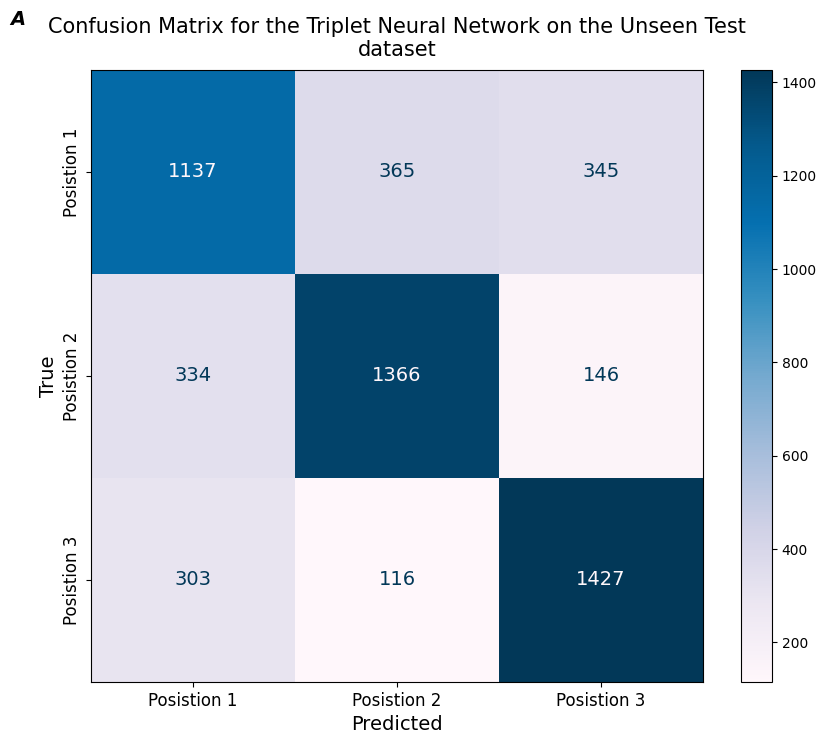

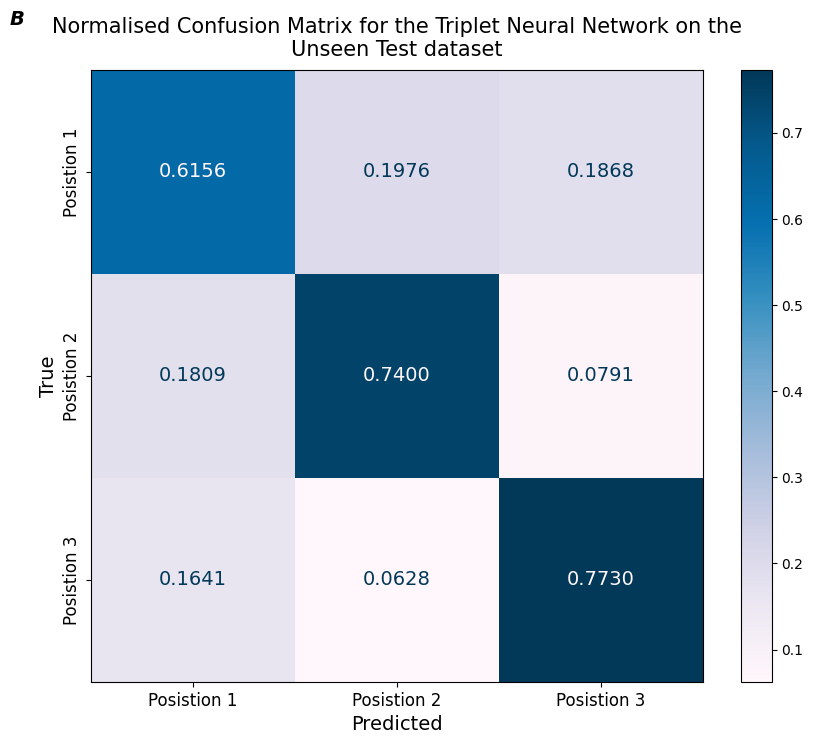

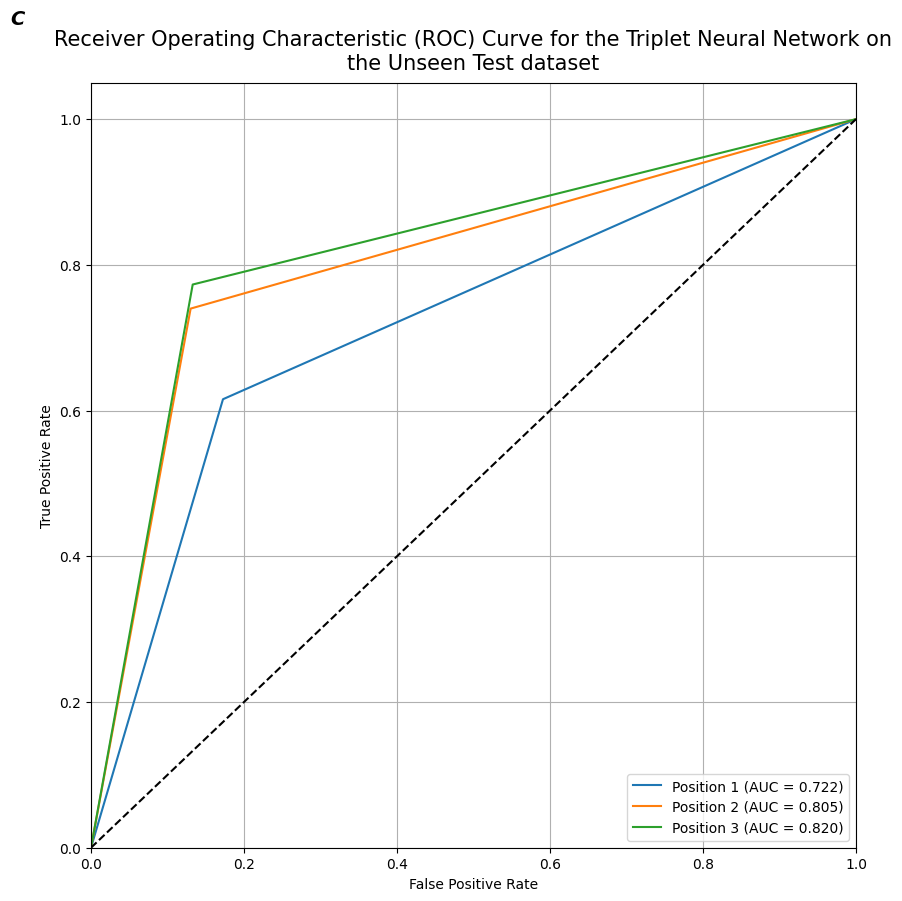

In [14]:
print("Evaluation on unseen test set")
sparsePreds = RDP_NN.predict(x=X_unseen)
y_preds = np.argmax(sparsePreds, axis=1)

print(classification_report(y_true=y_unseen_sparse.numpy(), y_pred=y_preds, digits = 4))

#Confusion Matrix not normalised.
disp, ax = StdConfMatrix(y_unseen_sparse.numpy(), y_preds, figure_number='A')
title = "Confusion Matrix for the Triplet Neural Network on the Unseen Test dataset"
wrapped_title = textwrap.fill(title, width=70)
ax.set_title(wrapped_title, pad=10, size=15) 
ax.set_yticklabels(
                labels=["Posistion 1", "Posistion 2", "Posistion 3"],
                rotation=90,
                va='center',  # Vertical alignment
                ha='center',  # Horizontal alignment
    ) 
ax.set_xticklabels(
                labels=["Posistion 1", "Posistion 2", "Posistion 3"],
                va='center',  # Vertical alignment
                ha='center',  # Horizontal alignment
    )
plt.show()

#Confusion Matrix normalised.
disp, ax = StdConfMatrix(y_unseen_sparse.numpy(), y_preds, normalise='true', format='.4f', figure_number='B')
title = "Normalised Confusion Matrix for the Triplet Neural Network on the Unseen Test dataset"
wrapped_title = textwrap.fill(title, width=70)
ax.set_title(wrapped_title, pad=10, size=15)
ax.set_yticklabels(
                labels=["Posistion 1", "Posistion 2", "Posistion 3"],
                rotation=90,
                va='center',  # Vertical alignment
                ha='center',  # Horizontal alignment
    ) 
ax.set_xticklabels(
                labels=["Posistion 1", "Posistion 2", "Posistion 3"],
                va='center',  # Vertical alignment
                ha='center',  # Horizontal alignment
    )

plt.show()


#ROC Curve
y_preds_onehot = tf.keras.utils.to_categorical(y_preds, num_classes=3)
y_test_onehot = tf.keras.utils.to_categorical(y_unseen_sparse.numpy(), num_classes=3)

plt = plot_roc_curves(y_test_onehot, y_preds_onehot, figure_number='C')
title = "Receiver Operating Characteristic (ROC) Curve for the Triplet Neural Network on the Unseen Test dataset"
wrapped_title = textwrap.fill(title, width=80)
plt.title(wrapped_title, pad=10, size=15) 
plt.savefig('figures/PNN_ROC')
plt.show()